# State estimation using an Extended Kalman Filter
This notebook uses PyTorch's autograd to simplify the computation of the Jacobian needed in the Extended Kalman Filter. States will be estimated for a dynamical system, the non-linear coupled set defined by Lorenz's equations, given a number of noisy observations. 

## Lorenz equations and numerical discretization


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def lorenz_torch(state, sigma, rho, beta):
    """
    state: tensor of shape (3,) or (..., 3)
    sigma, rho, beta: torch tensors (can require gradients)
    """
    x, y, z = state[..., 0], state[..., 1], state[..., 2]

    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z

    return torch.stack([dx, dy, dz], dim=-1)

def euler_step_torch(state, dt, sigma, rho, beta):
    return state + dt * lorenz_torch(state, sigma, rho, beta)

Let's write a function that can advance an initial state for a certain number of time steps.

In [3]:
def run_lorenz(state0, t0, steps, dt, sigma, rho, beta):
    state = state0
    trajectory = []
    time = []

    for i in range(steps):
        state = euler_step_torch(state, dt, sigma, rho, beta)
        trajectory.append(state)
        time.append(torch.tensor(t0 + (i + 1) * dt))

    return torch.stack(time), torch.stack(trajectory)

## Extended Kalman Filter description

The **Extended Kalman Filter (EKF)** is a nonlinear extension of the standard Kalman Filter. It estimates the state of a nonlinear dynamical system given noisy observations.

### State-Space Formulation

The system is modeled as:

**Process model (system dynamics):**
$$\mathbf{x}_{k} = f(\mathbf{x}_{k-1}) + \mathbf{w}_{k-1}$$

**Observation model (measurement):**
$$\mathbf{z}_{k} = h(\mathbf{x}_{k}) + \mathbf{v}_{k}$$

where:
- $\mathbf{x}_k$ is the state at time step $k$
- $\mathbf{z}_k$ is the observation/measurement at time $k$
- $f(\cdot)$ is the (possibly nonlinear) process function
- $h(\cdot)$ is the (possibly nonlinear) measurement function
- $\mathbf{w}_k \sim \mathcal{N}(0, \mathbf{Q})$ is the process noise
- $\mathbf{v}_k \sim \mathcal{N}(0, \mathbf{R})$ is the measurement noise
- $\mathbf{Q}$ is the process covariance matrix
- $\mathbf{R}$ is the measurement covariance matrix

### EKF Algorithm

**Prediction step:**
$$\hat{\mathbf{x}}_{k|k-1} = f(\hat{\mathbf{x}}_{k-1|k-1})$$
$$\mathbf{P}_{k|k-1} = \mathbf{F}_k \mathbf{P}_{k-1|k-1} \mathbf{F}_k^T + \mathbf{Q}$$

**Update step:**
$$\mathbf{y}_k = \mathbf{z}_k - h(\hat{\mathbf{x}}_{k|k-1})$$
$$\mathbf{S}_k = \mathbf{H}_k \mathbf{P}_{k|k-1} \mathbf{H}_k^T + \mathbf{R}$$
$$\mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{H}_k^T \mathbf{S}_k^{-1}$$
$$\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \mathbf{y}_k$$
$$\mathbf{P}_{k|k} = (\mathbf{I} - \mathbf{K}_k \mathbf{H}_k) \mathbf{P}_{k|k-1}$$

where:
- $\mathbf{F}_k = \frac{\partial f}{\partial \mathbf{x}}|_{\hat{\mathbf{x}}_{k-1|k-1}}$ is the Jacobian of the process function
- $\mathbf{H}_k = \frac{\partial h}{\partial \mathbf{x}}|_{\hat{\mathbf{x}}_{k|k-1}}$ is the Jacobian of the measurement function
- $\hat{\mathbf{x}}_{k|k}$ is the estimated state after observation
- $\mathbf{P}_{k|k}$ is the state covariance after observation
- $\mathbf{K}_k$ is the Kalman gain
- $\mathbf{y}_k$ is the innovation (measurement residual)
- $\mathbf{S}_k$ is the innovation covariance

The intention in this notebook is to obtain the Jacobians through PyTorch's autograd capabilities.

Let's start by defining the measurement function $h(\mathbf{x}_{k})$:

In [4]:
def hx(state):
    """
    Measurement function: observation = state (identity mapping)
    state: tensor of shape (3,) or (..., 3)
    returns: observation tensor of same shape
    """
   
    return state.clone()

In [5]:
def get_observations(state0, noise_std=0.5, thin_factor=1):
    # Fake "observed" data with measurement noise
    with torch.no_grad():
        true_time, true_traj = run_lorenz(
            state0,
            t0=0,
            steps=100,
            dt=0.01,
            sigma=torch.tensor(10.0),
            rho=torch.tensor(28.0),
            beta=torch.tensor(8/3),
        )
        # Add Gaussian noise to observations
        noise = torch.randn_like(true_traj) * noise_std
        noisy_traj = hx(true_traj) + noise
        return true_time[::thin_factor], noisy_traj[::thin_factor]

## Extended Kalman Filter Implementation

Here we implement the EKF using PyTorch's autograd to compute Jacobians automatically.


In [ ]:
class ExtendedKalmanFilter:
    def __init__(self, sigma, rho, beta, dt=0.01, Q=None, R=None):
        """
        Initialize the Extended Kalman Filter
        
        Args:
            sigma, rho, beta: Lorenz parameters
            dt: time step
            Q: process noise covariance (default: 1e-4 * I)
            R: measurement noise covariance (default: 0.5^2 * I)
        """
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt = dt
        
        # Default noise covariances
        self.Q = Q if Q is not None else 1e-4 * torch.eye(3)
        self.R = R if R is not None else (0.5**2) * torch.eye(3)
        
        # State estimate and covariance
        self.x = None
        self.P = None

        self.time = 0.0
        
    def process_function(self, state):
        """
        Process model: x_k = f(x_{k-1})
        One Euler step of Lorenz dynamics
        """
        return euler_step_torch(state, self.dt, self.sigma, self.rho, self.beta)
    
    def process_with_jacobian(self, state):
        """
        Compute Jacobian of process function using autograd
        F = ∂f/∂x evaluated at state
        """
        state_copy = state.clone().detach().requires_grad_(True)
        output = self.process_function(state_copy)
        
        # Compute Jacobian
        jacobian = torch.zeros(3, 3)
        for i in range(3):
            grad_output = torch.zeros_like(output)
            grad_output[i] = 1.0
            
            if state_copy.grad is not None:
                state_copy.grad.zero_()
            
            output.backward(grad_output, retain_graph=(i < 2))
            jacobian[i, :] = state_copy.grad.clone()
        
        return output, jacobian


    def measurement_with_jacobian(self, state):
        """
        Compute both the three measurements (one for each state) and its Jacobian in one call
        Returns: (z_pred, H)
        """
        state_copy = state.clone().detach().requires_grad_(True)
        z_pred = self.measurement_function(state_copy)
        
        # Compute Jacobian H
        H = torch.zeros(3, 3)
        for i in range(3):
            grad_output = torch.zeros_like(z_pred)
            grad_output[i] = 1.0
            
            if state_copy.grad is not None:
                state_copy.grad.zero_()
            
            z_pred.backward(grad_output, retain_graph=(i < 2))
            H[i, :] = state_copy.grad.clone()
        
        # Get the actual measurement value (without gradients)
        z_pred = z_pred.detach()
        
        return z_pred, H

    def measurement_function(self, state):
        """
        Measurement model: z_k = h(x_k)
        Identity mapping (we observe the full state)
        """
        return hx(state)
    
    def predict(self, time):
        """
        Prediction step of EKF
        x_{k|k-1} = f(x_{k-1|k-1})
        P_{k|k-1} = F_k * P_{k-1|k-1} * F_k^T + Q
        """
        while self.time + self.dt <= time:
            # Predict state
            self.x, F = self.process_with_jacobian(self.x.detach())
            self.time += self.dt
            
            # Predict covariance
            self.P = F @ self.P @ F.T + self.Q
        assert abs(time - self.time) < 1e-8, "Prediction time step mismatch"
    
    def update(self, z):
        """
        Update step of EKF given measurement z
        """
        # Compute predicted measurement and Jacobian H
        z_pred, H = self.measurement_with_jacobian(self.x)
        # Innovation (measurement residual)
        y = z - z_pred
        
        # Innovation covariance
        S = H @ self.P @ H.T + self.R
        
        # Kalman gain
        K = self.P @ H.T @ torch.linalg.inv(S)
        
        # Update state estimate
        self.x = self.x + K @ y
        
        # Update covariance estimate
        self.P = (torch.eye(3) - K @ H) @ self.P
        
        return y.norm().item()  # Return innovation magnitude
    
    def initialize(self, time, x0, P0=None):
        """
        Initialize filter with initial state and covariance
        """
        self.time = time
        self.x = x0.clone().detach()
        self.P = P0 if P0 is not None else torch.eye(3) * 1.0  # Initial uncertainty
    
    def filter(self, observations, times):
        """
        Run the EKF on a sequence of observations
        """
        estimates = []
        covariances = []
        innovations = []
        
        for i, (t, z) in enumerate(zip(times, observations)):
            self.predict(t)
            innov = self.update(z.clone().detach())
            
            estimates.append(self.x.clone().detach())
            covariances.append(self.P.clone().detach())
            innovations.append(innov)
        
        return torch.stack(estimates), covariances, innovations

Now let's test this EKF:

In [24]:
state0 = torch.tensor([1.0, 1.0, 1.0])
obs_times, obs_states = get_observations(state0, noise_std=2., thin_factor=4)

# Create and initialize EKF
ekf = ExtendedKalmanFilter(
    sigma=torch.tensor(10.0),
    rho=torch.tensor(28.0),
    beta=torch.tensor(8/3),
    dt=0.01,
    Q=0.2**2 * torch.eye(3),
    R=2.**2 * torch.eye(3)
)

ekf.initialize(time=0, x0=state0, P0=torch.eye(3) * 0.5)

# Run filter
estimated_states, cov_history, innovations = ekf.filter(obs_states, obs_times)

print(f"EKF filtering complete")
print(f"Mean innovation magnitude: {np.mean(innovations):.6f}")
print(f"Final estimated state: {estimated_states[-1]}")

EKF filtering complete
Mean innovation magnitude: 3.414339
Final estimated state: tensor([-4.0163, -5.5405, 18.5019])


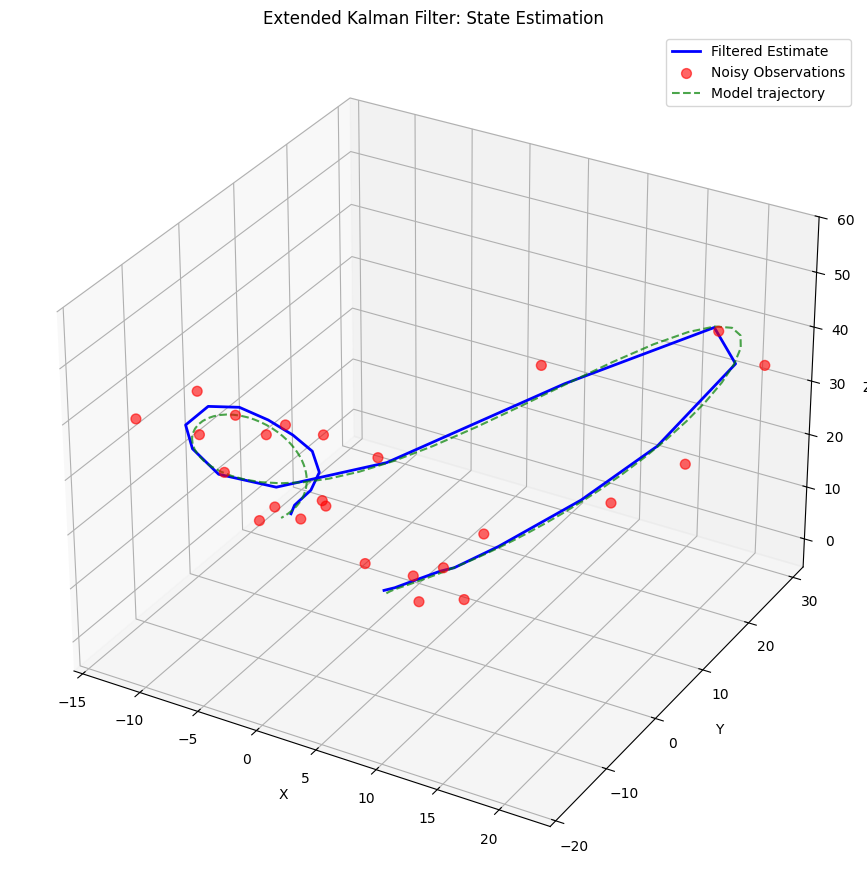

In [25]:
# Visualize the filtered trajectory
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the filtered trajectory
estimated_states_np = estimated_states.numpy()
ax.plot(estimated_states_np[:, 0], estimated_states_np[:, 1], estimated_states_np[:, 2], 
        'b-', linewidth=2, label='Filtered Estimate')

# Plot the observations as scatter points
obs_states_np = obs_states.numpy()
ax.scatter(obs_states_np[:, 0], obs_states_np[:, 1], obs_states_np[:, 2], 
          c='red', marker='o', s=50, alpha=0.6, label='Noisy Observations')

# Optional: plot the model for comparison
with torch.no_grad():
    _, true_traj = run_lorenz(
        state0,
        t0=0,
        steps=100,
        dt=0.01,
        sigma=torch.tensor(10.0),
        rho=torch.tensor(28.0),
        beta=torch.tensor(8/3),
    )
true_traj_np = true_traj.numpy()
ax.plot(true_traj_np[:, 0], true_traj_np[:, 1], true_traj_np[:, 2], 
        'g--', linewidth=1.5, alpha=0.7, label='Model trajectory')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Extended Kalman Filter: State Estimation')
ax.legend()
plt.tight_layout()
plt.show()